In [1]:
%matplotlib inline

import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import ddsp.training
import gin

from ddsp.training.preprocessing import F0LoudnessPreprocessor
from IPython.display import Audio
from f0_reduced_time_steps import data_generator_iof
from tfrecord_provider import CompleteTFRecordProvider

plt.style.use('dark_background')

In [2]:
gin_file_path = 'd:/soundofai/ddsp_trained_30k/operative_config-30000.gin'
ddsp_model_path = 'd:/soundofai/ddsp_trained_30k'
# Only looking at midi pitch = 60
tfrecord_path = os.path.join('d:/soundofai/prepare_pitch_60_data/pitch_60_dataset', 'test', 'complete.tfrecord')
data_iterable = iter(CompleteTFRecordProvider(tfrecord_path).get_batch(batch_size=1))

In [3]:
gin.parse_config_file(gin_file_path)
ddsp_model = ddsp.training.models.Autoencoder(encoder=None)
ddsp_model.restore(ddsp_model_path)

model = tf.keras.models.load_model('checkpoints/f0_clipped_to_root_val_loss_0.0016.h5')
data_generator = data_generator_iof(data_iterable)

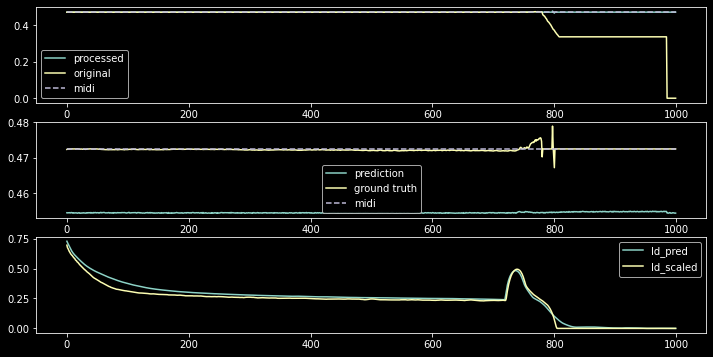

In [127]:
(inputs, outputs), features = next(data_generator)
f0_pred, ld_pred = model.predict(inputs)
f0_pred = np.squeeze(f0_pred)

f0_scaled = outputs['f0_scaled']
pitch = inputs['pitch']

def plot_results(start=0, end=1000):
    plt.figure(figsize=(12, 6))

    plt.subplot(3, 1, 1)
    plt.plot(f0_scaled[0, start:end], label='processed')
    plt.plot(features['f0_scaled'][0, start:end], label='original')
    plt.plot([np.squeeze(pitch)] * (end - start), '--', label='midi')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(f0_pred[start:end], label='prediction')
    plt.plot(f0_scaled[0, start:end], label='ground truth')
    plt.plot([np.squeeze(pitch)] * (end - start), '--', label='midi')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(ld_pred[0, start: end], label='ld_pred')
    plt.plot(outputs['ld_scaled'][0, start: end], label='ld_scaled')
    plt.legend()

    plt.show()

plot_results()

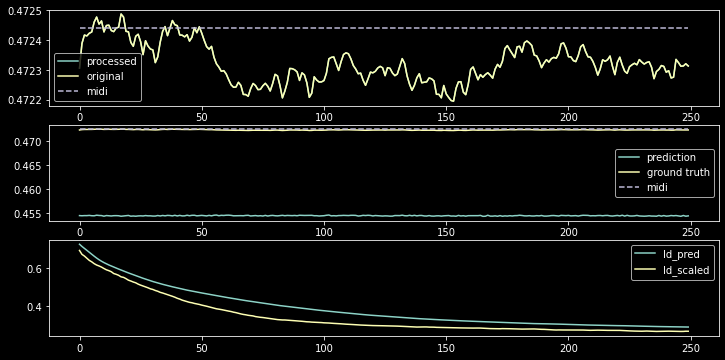

In [128]:
plot_results(0, 250)

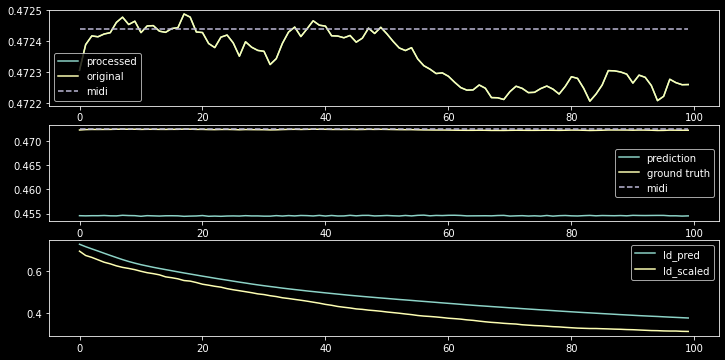

In [129]:
plot_results(0, 100)

In [130]:
# try to see how a flat frequency at root works
f0_root = np.ones((1, 1000)) * pitch.numpy()
f0_hz_1, loudness_db_1 = F0LoudnessPreprocessor.invert_scaling(f0_pred, ld_pred)
f0_hz_2, loudness_db_2 = F0LoudnessPreprocessor.invert_scaling(f0_root, ld_pred)

ddsp_input_1 = {
    'f0_hz': np.reshape(f0_hz_1, (1, 1000)),
    'loudness_db': np.reshape(features['loudness_db'], (1, 1000)),
    'z': np.reshape(features['z'], (1, 1000, 16))
}

ddsp_input_2 = {
    'f0_hz': np.reshape(f0_hz_2, (1, 1000)),
    'loudness_db': np.reshape(features['loudness_db'], (1, 1000)),
    'z': np.reshape(features['z'], (1, 1000, 16))
}

ddsp_outputs_1 = ddsp_model(ddsp_input_1, training=False)
audio_pred_1 = ddsp_model.get_audio_from_outputs(ddsp_outputs_1)

ddsp_outputs_2 = ddsp_model(ddsp_input_2, training=False)
audio_pred_2 = ddsp_model.get_audio_from_outputs(ddsp_outputs_2)

audio = features['audio']

In [131]:
print('Original audio')
Audio(np.squeeze(audio), rate=16000)

Original audio


In [132]:
print('Predicted audio with prior z value')
Audio(np.squeeze(audio_pred_1), rate=16000)

Predicted audio with prior z value


In [133]:
print('Predicted audio with prior z value and fixed f0_root')
Audio(np.squeeze(audio_pred_2), rate=16000)

Predicted audio with prior z value and fixed f0_root


array([[0.47244096]], dtype=float32)